### Imports & Logging Setup

In [1]:
import os
import numpy as np
import pandas as pd
import warnings
import logging

# Machine Learning
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, make_scorer

# Suppress warnings
warnings.simplefilter("ignore")

# Logging setup
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

### Load Data & Select Features

In [2]:
# File paths (Updated to include NCA and RFE)
file_paths = {
    "fold_change": "../results/fold_change_results.csv",
    "chi_squared": "../results/chi_squared_features.csv",
    "information_gain": "../results/information_gain_results.csv",
    "lasso": "../results/lasso_results.csv",
    "nca": "../results/nca_results.csv",
    "rfe": "../results/recursive_feature_elimination/recursive_feature_selection_general.csv",
    "processed_data": "../processed_data/miRNA_stage_subtype.csv"
}

# Define the target task
target_task = "diagnosis"  # options: "diagnosis", "stage", "subtype"

# Function to load features specific to the classification task
# Function to load features by task but explicitly exclude label columns
def load_features_by_task(file_paths, target, num_features=10):
    feature_sets = {}
    # Label columns that should never be included as features
    label_columns = ['diagnosis', 'stage', 'subtype']

    for key, path in file_paths.items():
        if key == "processed_data":
            continue

        if os.path.exists(path):
            df = pd.read_csv(path)

            # Use column matching to pull task-specific columns if available
            if target in df.columns:
                features = set(df.nlargest(num_features, target)["Feature"])
                # Filter out any label columns
                features = {f for f in features if f not in label_columns}
                feature_sets[key] = features

            # Handle known formats for specific methods
            elif key == "fold_change" and "log2_fold_change" in df.columns:
                features = set(df.nlargest(num_features, "log2_fold_change")["Unnamed: 0"])
                features = {f for f in features if f not in label_columns}
                feature_sets[key] = features
            elif key == "chi_squared" and "Score" in df.columns:
                features = set(df.nlargest(num_features, "Score")["Feature"])
                features = {f for f in features if f not in label_columns}
                feature_sets[key] = features
            elif key == "information_gain" and "Info_Gain_General" in df.columns:
                features = set(df.nlargest(num_features, "Info_Gain_General")["Feature"])
                features = {f for f in features if f not in label_columns}
                feature_sets[key] = features
            elif key == "lasso" and "Coefficient" in df.columns:
                features = set(df.nlargest(num_features, "Coefficient")["Feature"])
                features = {f for f in features if f not in label_columns}
                feature_sets[key] = features
            elif key in ["nca", "rfe"] and "Feature" in df.columns:
                features = set(df["Feature"][:num_features])
                features = {f for f in features if f not in label_columns}
                feature_sets[key] = features
            else:
                logging.warning(f"Unexpected format in {key}, skipping.")
        else:
            logging.warning(f"Feature selection file missing: {path}")

    combined_features = set()
    if feature_sets:
        combined_features = set().union(*feature_sets.values())
    combined_features = {f for f in combined_features if f not in label_columns}  # Final filter
    logging.info(f"[{target.upper()}] Total unique features selected: {len(combined_features)}")
    return list(combined_features)

# Select features for the current task
num_features_to_select = 10
top_features = load_features_by_task(file_paths, target_task, num_features=num_features_to_select)

2025-03-29 09:32:39,114 - INFO - [DIAGNOSIS] Total unique features selected: 56


### Process Features & Labels for Multi-Output Classification

In [3]:
# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Ensure processed data is loaded
file_path = file_paths.get("processed_data", None)
if file_path and os.path.exists(file_path):
    processed_data = pd.read_csv(file_path)
    logging.info(f"Processed data loaded successfully. Shape: {processed_data.shape}")
else:
    raise FileNotFoundError(f"Processed data file is missing: {file_path}")

# Debug: Print column names
print("\nAvailable columns in processed_data:")
print(processed_data.columns)

# Create "diagnosis" column if missing
if "diagnosis" not in processed_data.columns:
    logging.warning("Column 'diagnosis' is missing. Deriving from 'subtype'.")
    processed_data["diagnosis"] = processed_data["subtype"].apply(lambda x: 0 if x == 0 else 1)
    logging.info("'diagnosis' column successfully created.")

# Ensure the specific label exists
if target_task not in processed_data.columns:
    raise KeyError(f"Missing expected label column: '{target_task}'.")

# Function to process features and labels
def process_features_and_labels(processed_data, selected_features, target):
    """
    Filters processed data for selected features and extracts the target label.

    Args:
        processed_data (pd.DataFrame): Data containing features and target variables.
        selected_features (list): List of feature names to filter.
        target (str): Target column name.

    Returns:
        tuple: Processed feature dataframe (X) and label series (y).
    """
    # Define label columns to explicitly exclude
    label_columns = ['diagnosis', 'stage', 'subtype']
    
    # Remove label columns from features list
    selected_features = [f for f in selected_features if f not in label_columns]
    
    missing_features = [f for f in selected_features if f not in processed_data.columns]
    if missing_features:
        logging.warning(f"{len(missing_features)} features missing from dataset! Missing: {missing_features}")

    # Stop if more than 50% of features are missing
    missing_ratio = len(missing_features) / len(selected_features) if selected_features else 1.0
    if missing_ratio > 0.5:
        raise ValueError(f"More than 50% of selected features are missing! ({missing_ratio * 100:.2f}%)")

    selected_features = [f for f in selected_features if f in processed_data.columns]

    # Final safety check - make sure we don't include any label columns
    selected_features = [f for f in selected_features if f not in label_columns]
    
    # Log the actual features being used
    logging.info(f"Using {len(selected_features)} features for {target} prediction")
    logging.info(f"First 10 features: {selected_features[:10]}")

    # Extract features and target label
    X = processed_data[selected_features].apply(pd.to_numeric, errors='coerce')
    y = processed_data[target].astype(int)

    # Handle missing values
    if X.isnull().values.any() or y.isnull().values.any():
        logging.warning("Missing values detected in features or labels.")
        print("\nMissing values per feature (Top 5):")
        print(X.isnull().sum()[X.isnull().sum() > 0].head())
        print("\nMissing values in target:")
        print(y.isnull().sum())
        valid_indices = ~(X.isnull().any(axis=1) | y.isnull())
        X = X[valid_indices]
        y = y[valid_indices]

    # Standardize features
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    logging.info("Features have been standardized.")

    # Stratified train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    logging.info(f"Training Set Shape: {X_train.shape}")
    logging.info(f"Test Set Shape: {X_test.shape}")
    logging.info(f"Class distribution in training set:\n{y_train.value_counts(normalize=True)}")

    return X_train, X_test, y_train, y_test

def verify_no_label_leakage(X_train, y_train, label_columns=['diagnosis', 'stage', 'subtype']):
    """Verify that none of the label columns are included in the feature set."""
    overlap = set(X_train.columns).intersection(set(label_columns))
    if overlap:
        logging.error(f"CRITICAL ERROR: Label leakage detected! Found label columns in features: {overlap}")
        raise ValueError(f"Label leakage detected! Found {overlap} in features")
    
    # Check if any feature has perfect correlation with the target
    high_corr_features = []
    for col in X_train.columns:
        feature_values = X_train[col].values
        correlation = np.abs(np.corrcoef(feature_values, y_train)[0, 1])
        if correlation > 0.95:  # Very high correlation might indicate leakage
            high_corr_features.append((col, correlation))
    
    if high_corr_features:
        logging.warning(f"Potential data leakage! Found features with very high correlation to target:")
        for feature, corr in sorted(high_corr_features, key=lambda x: x[1], reverse=True):
            logging.warning(f"  - {feature}: correlation = {corr:.4f}")
    
    logging.info("No label columns found in features - proceeding with training")

# Process the data for current task (just call it once)
X_train, X_test, y_train, y_test = process_features_and_labels(processed_data, top_features, target_task)

# Verify no label leakage
verify_no_label_leakage(X_train, y_train)

# Debug
print("\nExpression values sample:")
print(X_train.head())

print("\nFeature statistics:")
print(X_train.describe())

print(f"\nClass proportions in train set for '{target_task}':")
print(y_train.value_counts(normalize=True))

2025-03-29 09:32:42,243 - INFO - Processed data loaded successfully. Shape: (1091, 1883)
2025-03-29 09:32:42,244 - WARNING - Column 'diagnosis' is missing. Deriving from 'subtype'.
2025-03-29 09:32:42,246 - INFO - 'diagnosis' column successfully created.
2025-03-29 09:32:42,247 - INFO - Using 56 features for diagnosis prediction
2025-03-29 09:32:42,248 - INFO - First 10 features: ['hsa-mir-1283-2', 'hsa-mir-760', 'hsa-mir-19a', 'hsa-mir-8066', 'hsa-mir-4663', 'hsa-mir-5690', 'hsa-mir-509-1', 'hsa-mir-4703', 'hsa-mir-523', 'hsa-mir-6770-1']
2025-03-29 09:32:42,256 - INFO - Features have been standardized.
2025-03-29 09:32:42,258 - INFO - Training Set Shape: (872, 56)
2025-03-29 09:32:42,258 - INFO - Test Set Shape: (219, 56)
2025-03-29 09:32:42,261 - INFO - Class distribution in training set:
diagnosis
1    0.989679
0    0.010321
Name: proportion, dtype: float64
2025-03-29 09:32:42,269 - INFO - No label columns found in features - proceeding with training



Available columns in processed_data:
Index(['hsa-let-7a-1', 'hsa-let-7a-2', 'hsa-let-7a-3', 'hsa-let-7b',
       'hsa-let-7c', 'hsa-let-7d', 'hsa-let-7e', 'hsa-let-7f-1',
       'hsa-let-7f-2', 'hsa-let-7g',
       ...
       'hsa-mir-943', 'hsa-mir-944', 'hsa-mir-95', 'hsa-mir-9500',
       'hsa-mir-96', 'hsa-mir-98', 'hsa-mir-99a', 'hsa-mir-99b', 'stage',
       'subtype'],
      dtype='object', length=1883)

Expression values sample:
     hsa-mir-1283-2  hsa-mir-760  hsa-mir-19a  hsa-mir-8066  hsa-mir-4663  \
459       -0.067550    -0.521584    -0.410015     -0.055165     -0.058129   
765       -0.055086    -0.575515    -0.545796     -0.055165     -0.058129   
749       -0.067550    -0.613479     0.223875     -0.055165     -0.058129   
990       -0.067550    -0.613479    -0.383967     -0.055165     -0.058129   
270       -0.048564    -0.574927    -0.583255     -0.055165     -0.058129   

     hsa-mir-5690  hsa-mir-509-1  hsa-mir-4703  hsa-mir-523  hsa-mir-6770-1  \
459      0.61476

### Train-Test Split & Feature Scaling

In [4]:
# Log Split Info
print("\nTrain-Test Split Information:")
print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")

# Print distribution of diagnosis labels
print("\nTraining set class distribution (Diagnosis):")
print(y_train.value_counts(normalize=True))

print("\nTesting set class distribution (Diagnosis):")
print(y_test.value_counts(normalize=True))


Train-Test Split Information:
Training set: (872, 56), Testing set: (219, 56)

Training set class distribution (Diagnosis):
diagnosis
1    0.989679
0    0.010321
Name: proportion, dtype: float64

Testing set class distribution (Diagnosis):
diagnosis
1    0.990868
0    0.009132
Name: proportion, dtype: float64


### Train Multi-Output SVM Model

In [5]:
import warnings
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Suppress warnings
warnings.simplefilter("ignore")

# Define Hyperparameter Grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.1, 1, 10],
    'kernel': ['rbf']
}

print(f"\nTraining SVM for {target_task.upper()}...")

# Define & train model
svm = SVC(class_weight="balanced", random_state=42)
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train, y_train)

# Predict
y_pred = grid_search.best_estimator_.predict(X_test)

# Optional: Label names
target_names = ["Healthy  0", "Cancer  1"]

# Report
print(f"\nBest SVM Hyperparameters for {target_task.upper()}: {grid_search.best_params_}")
print(f"\nClassification Report for {target_task.upper()}:\n",
      classification_report(y_test, y_pred, target_names=target_names, zero_division=0))


Training SVM for DIAGNOSIS...

Best SVM Hyperparameters for DIAGNOSIS: {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}

Classification Report for DIAGNOSIS:
               precision    recall  f1-score   support

  Healthy  0       0.00      0.00      0.00         2
   Cancer  1       0.99      1.00      1.00       217

    accuracy                           0.99       219
   macro avg       0.50      0.50      0.50       219
weighted avg       0.98      0.99      0.99       219



### Evaluate Multi-Output Model & Feature Selection Insights


-------------------- SVM_Diagnosis Results --------------------
Accuracy: 0.9909
Sensitivity (Recall): 1.0000
Specificity: 0.0000

Confusion Matrix:
 [[  0   2]
 [  0 217]]

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.99      1.00      1.00       217

    accuracy                           0.99       219
   macro avg       0.50      0.50      0.50       219
weighted avg       0.98      0.99      0.99       219


Confusion matrix saved to ../results/svm/svm_diagnosis_confusion_matrix.png


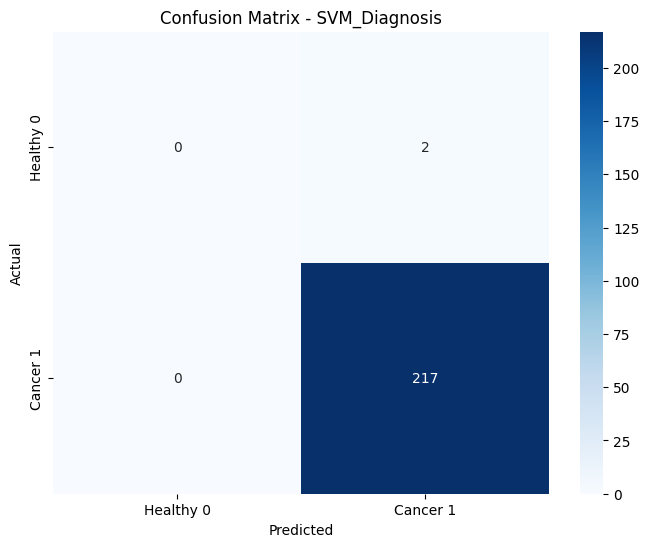

2025-03-29 09:32:56,717 - INFO - Model Evaluation Completed for SVM_Diagnosis!
2025-03-29 09:32:56,718 - INFO - Accuracy: 0.9909
2025-03-29 09:32:56,718 - INFO - Sensitivity: 1.0000
2025-03-29 09:32:56,719 - INFO - Specificity: 0.0000



Correlation matrix saved to ../results/svm/svm_diagnosis_correlation_matrix.png


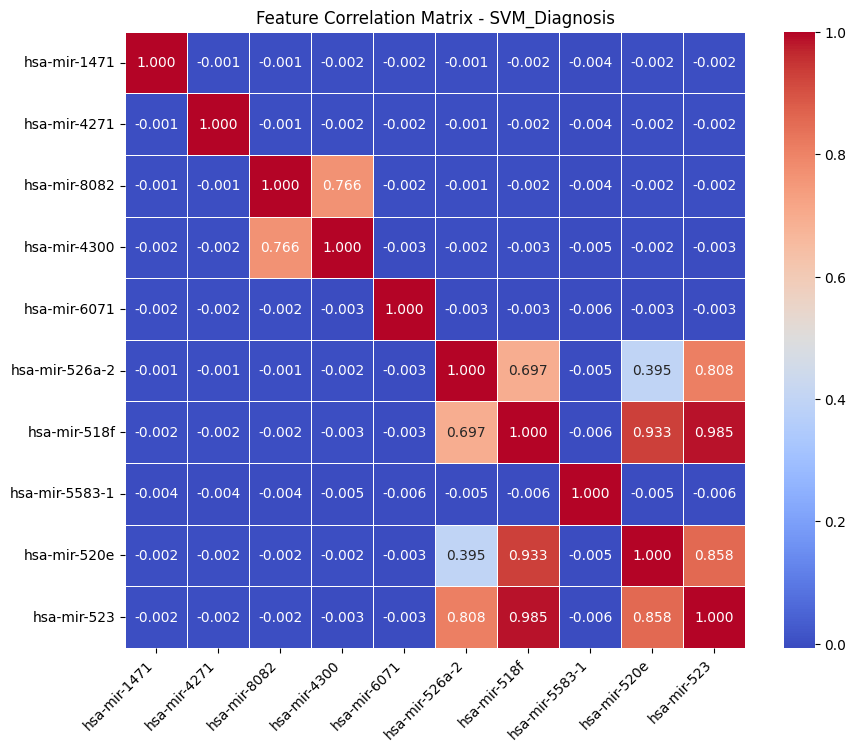


Covariance matrix saved to ../results/svm/svm_diagnosis_covariance_matrix.png


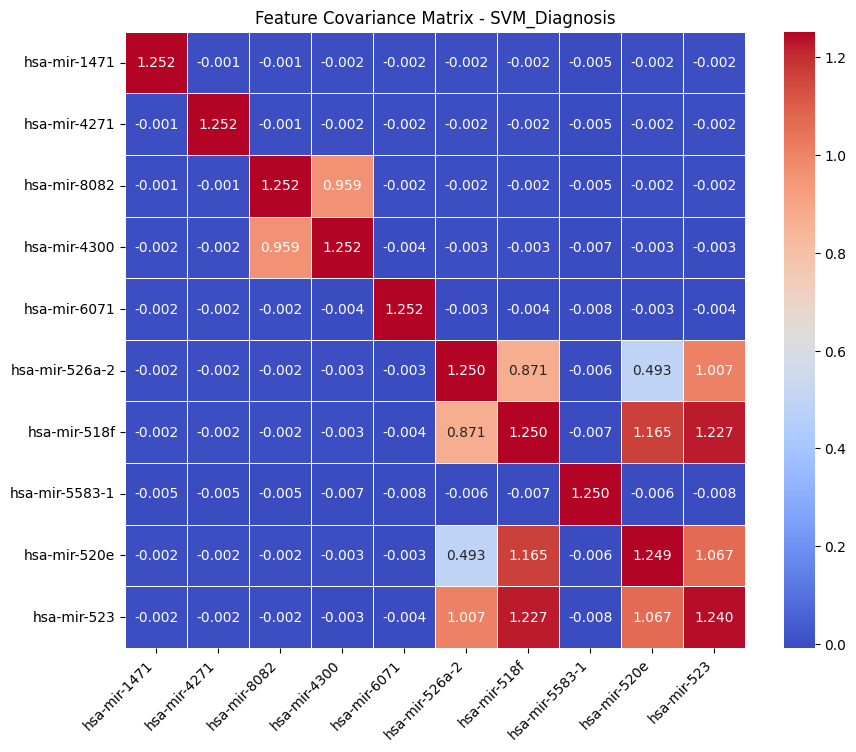


Top 10 Features Based on Maximum Variance:
['hsa-mir-1471', 'hsa-mir-4271', 'hsa-mir-8082', 'hsa-mir-4300', 'hsa-mir-6071', 'hsa-mir-526a-2', 'hsa-mir-518f', 'hsa-mir-5583-1', 'hsa-mir-520e', 'hsa-mir-523']

Top features saved to ../results/svm/svm_diagnosis_top_features.txt


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import logging
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Logging Setup
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

def evaluate_model(y_test, y_pred, X_train, model_name, save_dir="../results/svm/"):
    os.makedirs(save_dir, exist_ok=True)  # Ensure directory exists

    # Compute Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    # Compute Accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Compute Sensitivity & Specificity
    if cm.shape == (2, 2):  # Binary classification
        tn, fp, fn, tp = cm.ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    else:  # Multiclass
        sensitivity = np.mean(np.diag(cm) / np.sum(cm, axis=1))
        specificity = np.mean(np.diag(cm) / np.sum(cm, axis=0))

    # Print Metrics
    print(f"\n{'-'*20} {model_name} Results {'-'*20}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Sensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print("\nConfusion Matrix:\n", cm)

    # Classification Report
    report = classification_report(y_test, y_pred, zero_division=0)
    print("\nClassification Report:\n", report)

    # Confusion Matrix Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                xticklabels=["Healthy 0", "Cancer 1"], yticklabels=["Healthy 0", "Cancer 1"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    cm_path = os.path.join(save_dir, f"{model_name.lower()}_confusion_matrix.png")
    plt.savefig(cm_path)
    print(f"\nConfusion matrix saved to {cm_path}")
    plt.show()

    # Log Evaluation
    logging.info(f"Model Evaluation Completed for {model_name}!")
    logging.info(f"Accuracy: {accuracy:.4f}")
    logging.info(f"Sensitivity: {sensitivity:.4f}")
    logging.info(f"Specificity: {specificity:.4f}")

    # Top 10 Features by Variance
    top_variance_features = X_train.var().sort_values(ascending=False).index[:10]

    # Correlation Matrix
    corr_matrix = X_train[top_variance_features].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".3f", linewidths=0.5)
    plt.title(f"Feature Correlation Matrix - {model_name}")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    corr_path = os.path.join(save_dir, f"{model_name.lower()}_correlation_matrix.png")
    plt.savefig(corr_path)
    print(f"\nCorrelation matrix saved to {corr_path}")
    plt.show()

    # Covariance Matrix
    cov_matrix = X_train[top_variance_features].cov()
    plt.figure(figsize=(10, 8))
    sns.heatmap(cov_matrix, annot=True, cmap="coolwarm", fmt=".3f", linewidths=0.5)
    plt.title(f"Feature Covariance Matrix - {model_name}")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    cov_path = os.path.join(save_dir, f"{model_name.lower()}_covariance_matrix.png")
    plt.savefig(cov_path)
    print(f"\nCovariance matrix saved to {cov_path}")
    plt.show()

    # Save Top Features
    top_features_path = os.path.join(save_dir, f"{model_name.lower()}_top_features.txt")
    top_10_features = top_variance_features.tolist()
    with open(top_features_path, "w") as f:
        for feature in top_10_features:
            f.write(feature + "\n")
    print("\nTop 10 Features Based on Maximum Variance:")
    print(top_10_features)
    print(f"\nTop features saved to {top_features_path}")

    return {
        "accuracy": accuracy,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "confusion_matrix": cm.tolist(),
        "classification_report": report,
        "top_10_features": top_10_features
    }

# Diagnosis-Only Evaluation Call
model_name = "SVM_Diagnosis"
metrics = evaluate_model(y_test, y_pred, X_train, model_name=model_name)


### Save Everything & Finalize the Pipeline

In [7]:
import os
import json
import pandas as pd
import joblib
import logging

# Configure Logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Define Output Directory
output_dir = "../results/svm/"
os.makedirs(output_dir, exist_ok=True)  # Ensure directory exists

# Save Predictions
pred_path = os.path.join(output_dir, "svm_predictions_diagnosis.csv")
pd.DataFrame({
    "actual": y_test,
    "predicted": y_pred
}).to_csv(pred_path, index=False)
logging.info(f"Diagnosis predictions saved to {pred_path}")

# Save Metadata
metadata = {
    "diagnosis_hyperparameters": metrics["classification_report"],
    "diagnosis_accuracy": metrics["accuracy"],
    "sensitivity_diagnosis": metrics["sensitivity"],
    "specificity_diagnosis": metrics["specificity"],
    "top_10_features_diagnosis": metrics["top_10_features"],
    "train_size": X_train.shape[0],
    "test_size": X_test.shape[0],
    "model_file_format": "joblib"  # Note the format change
}

metadata_path = os.path.join(output_dir, "svm_diagnosis_metadata.json")
with open(metadata_path, "w") as f:
    json.dump(metadata, f, indent=4)
logging.info(f"Metadata saved to {metadata_path}")

# Save Trained Model
model_path = os.path.join(output_dir, "svm_model_diagnosis.joblib")
joblib.dump(grid_search.best_estimator_, model_path)
logging.info(f"Diagnosis model saved to {model_path}")

# Log completion
print("\nAll results successfully saved. The SVM pipeline for diagnosis is complete!")

2025-03-29 09:33:02,288 - INFO - Diagnosis predictions saved to ../results/svm/svm_predictions_diagnosis.csv
2025-03-29 09:33:02,290 - INFO - Metadata saved to ../results/svm/svm_diagnosis_metadata.json
2025-03-29 09:33:02,293 - INFO - Diagnosis model saved to ../results/svm/svm_model_diagnosis.joblib



All results successfully saved. The SVM pipeline for diagnosis is complete!
